As Welf said, we can skip the data generation step....

### 1.3 Load the (generated) data and get an overview

In [21]:
import pandas as pd

feature_names = ['n_50', 'n_150', 'n_300', 'd_50', 'd_150', 'd_300', 't_peak', 'x_500']
df = pd.read_csv('/media/home/ngundermann/workspace/DML_notebooks/data/epidemic_process.csv', names=feature_names)
df.head()

,n_50,n_150,n_300,d_50,d_150,d_300,t_peak,x_500
0,5.484789,31.727771,6.910956,1.086088,0.364691,-1.167716,155.625779,0.956636
1,8.578305,34.552430,3.908585,1.464196,-4.350747,-0.664125,120.744595,0.982187
2,1.525187,3.581051,7.528895,0.077954,0.445827,0.030962,357.805297,0.472349
3,6.151596,33.205968,6.199945,1.148558,-1.573964,-0.617079,133.964974,0.961004
4,4.443471,30.324971,8.335484,0.970687,2.765872,-1.672065,162.800388,0.881936


Plot the emperical cumulative probability distributions (CDFs) of the random variables (features).

count    50.000000
mean      5.510800
std       3.396421
min       1.129245
25%       3.309000
50%       4.422730
75%       6.106346
max      18.092522
Name: n_50, dtype: float64


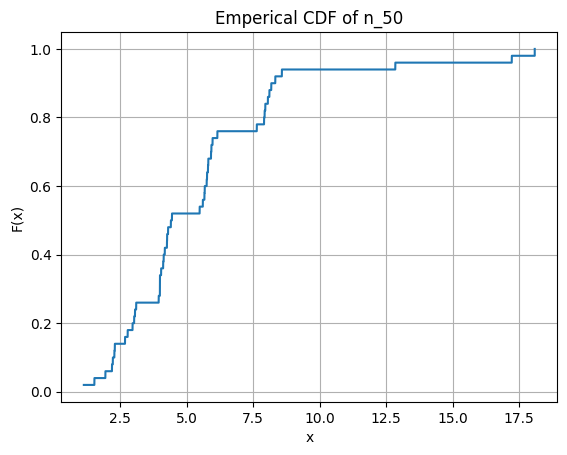

count    50.000000
mean     26.084033
std       9.348820
min       1.507993
25%      21.595062
50%      30.329100
75%      33.676859
max      35.575905
Name: n_150, dtype: float64


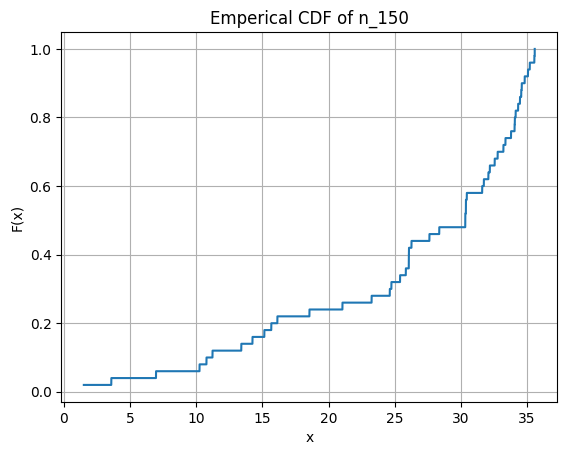

count    50.000000
mean      8.145338
std       3.640636
min       1.868088
25%       5.353104
50%       7.347345
75%      10.167518
max      15.466792
Name: n_300, dtype: float64


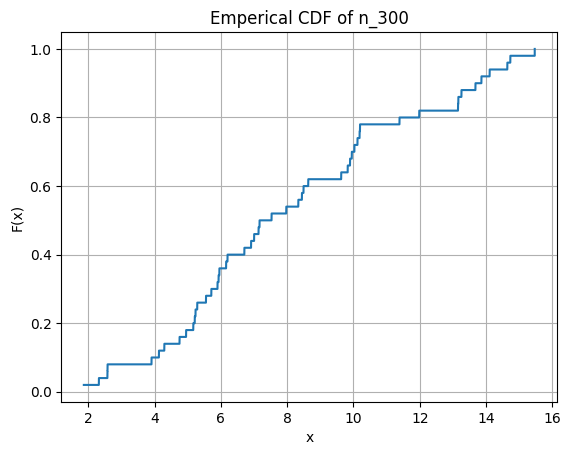

count    50.000000
mean      1.097608
std       0.784262
min       0.032972
25%       0.703376
50%       0.952191
75%       1.310096
max       3.940195
Name: d_50, dtype: float64


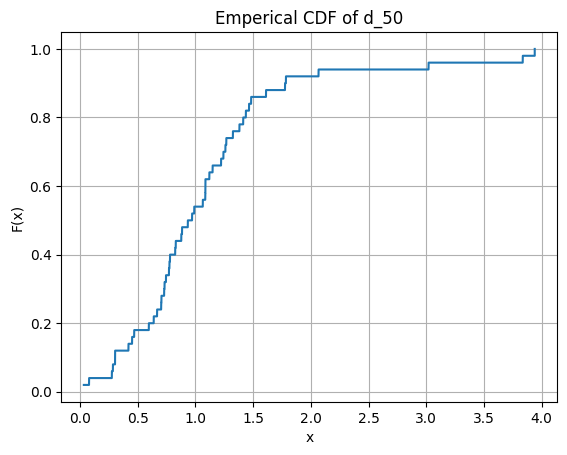

count    50.000000
mean      0.507043
std       2.193691
min      -4.539801
25%      -0.997498
50%       1.229447
75%       2.155732
max       3.846155
Name: d_150, dtype: float64


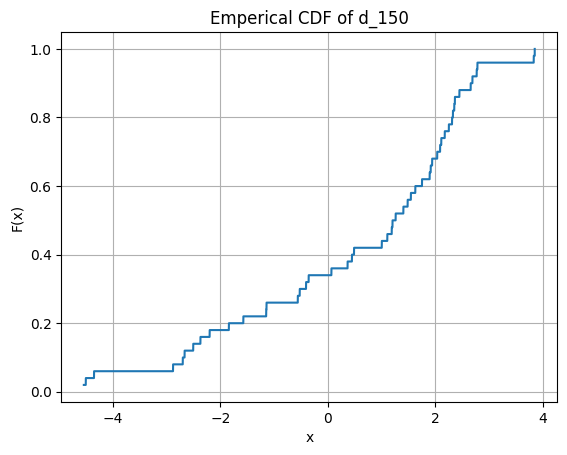

count    50.000000
mean     -1.249822
std       0.540493
min      -2.244317
25%      -1.647766
50%      -1.278831
75%      -0.904246
max       0.030962
Name: d_300, dtype: float64


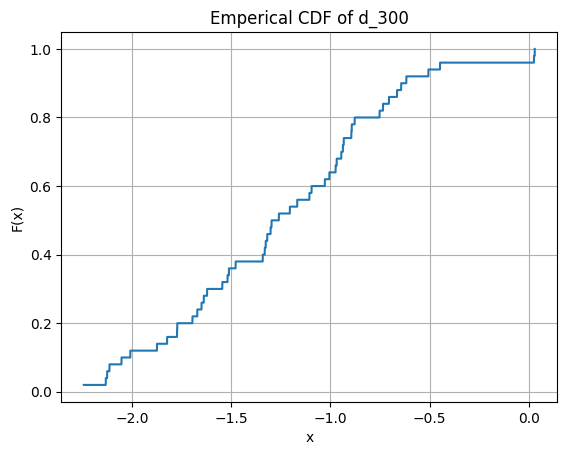

count     50.000000
mean     167.165455
std       63.076660
min       92.341618
25%      128.262318
50%      150.599951
75%      187.041275
max      445.305297
Name: t_peak, dtype: float64


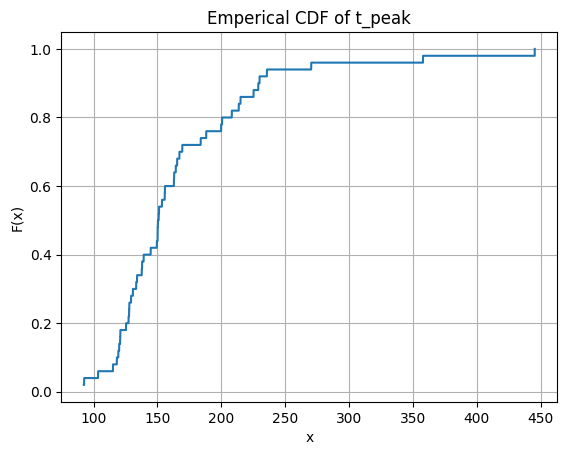

count    50.000000
mean      0.898774
std       0.141293
min       0.147541
25%       0.878408
50%       0.939200
75%       0.974210
max       1.003071
Name: x_500, dtype: float64


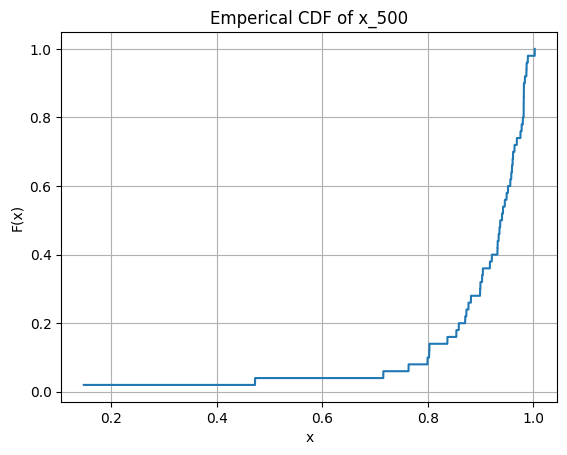

In [22]:
import matplotlib.pyplot as plt
from scipy.stats import cumfreq
import numpy as np

for f in feature_names:
    print(df[f].describe())

    cum_freq = cumfreq(df[f], numbins=100000)

    cum_prob = cum_freq.cumcount / len(df[f])

    # Plot the CDF
    plt.plot(cum_freq.lowerlimit + np.linspace(0, cum_freq.binsize*cum_freq.cumcount.size, cum_freq.cumcount.size), cum_prob)
    plt.xlabel('x')
    plt.ylabel('F(x)')
    plt.title(f'Emperical CDF of {f}')
    plt.grid(True)
    plt.show()

Recall, the sample mean value is an approximation of the expected value, or expectation of the
random variable. The sample variance is the square of the sample standard deviation std.

Check the correlation between the features.

<Axes: >

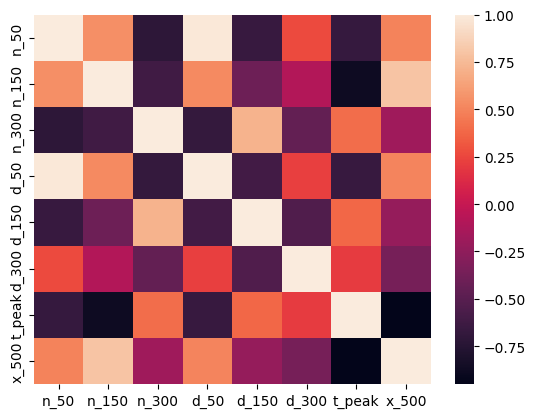

In [23]:
import seaborn as sns
correlation = df.corr()
sns.heatmap(correlation)

Recall, the (sample) correlation of two (samples of) random variables X and Y their (sample)
covariance normalized (divided) by the product of their (sample) standard deviation.

*Discuss your findings. Your answer goes here.*

### 1.4 Try to fit parametric probability distributions

We go through a set of common probability distributions and try to fit any of them to the data.
We use the Chi-square and the Kolmogorov-Smirnov tests to check the goodness of fit.
*Note that fitting and testing using the same data is actually not quite correct. We should use cross-validation.* 

*Student: ... I neglected it, too.*


Check for feature: n_50
Normal with 5% significance level
Params: (5.510799932725158, 3.362285673435535)


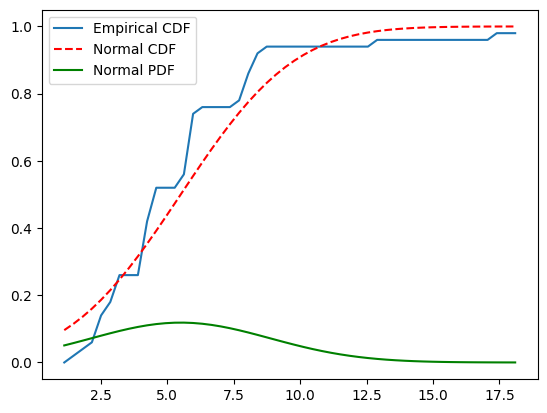


Check for feature: n_150
Not Normal with 5% significance level
Not Poisson with 5% significance level
Not Exponetial with 5% significance level
Not Gamma with 5% significance level
Not ExtremeValue with 5% significance level
Not Kernel with 5% significance level

Check for feature: n_300
Normal with 5% significance level
Params: (8.145337883057707, 3.6040461200663736)


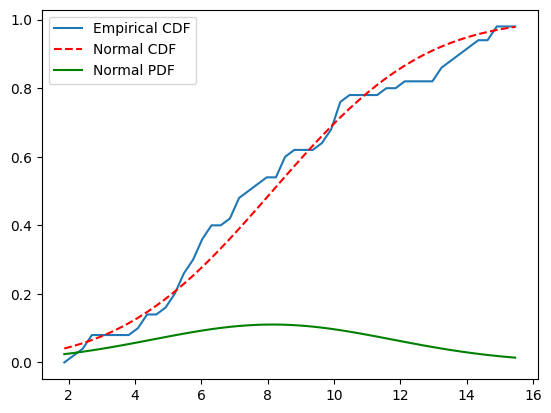


Check for feature: d_50
Normal with 5% significance level
Params: (1.0976084202155842, 0.7763794279146738)


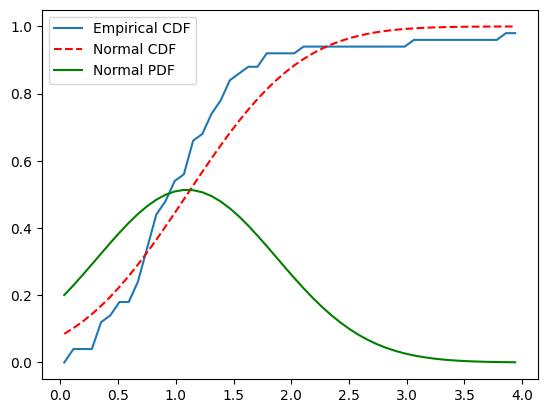


Check for feature: d_150
Not Normal with 5% significance level
Not Exponetial with 5% significance level
Not ExtremeValue with 5% significance level
Not Kernel with 5% significance level

Check for feature: d_300
Normal with 5% significance level
Params: (-1.249822268966371, 0.5350603552002773)


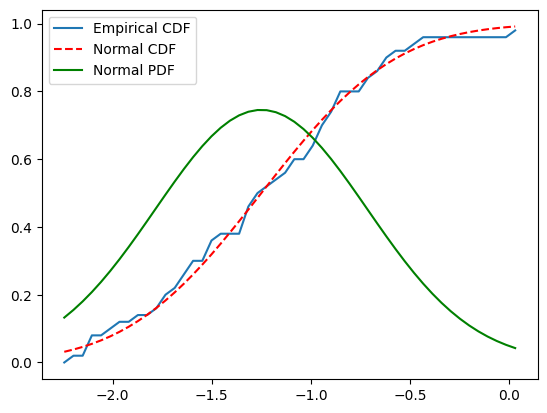


Check for feature: t_peak
Not Normal with 5% significance level
Not Poisson with 5% significance level
Not Exponetial with 5% significance level
Not Gamma with 5% significance level
Not ExtremeValue with 5% significance level
Not Kernel with 5% significance level

Check for feature: x_500
Not Normal with 5% significance level
Not Poisson with 5% significance level
Not Exponetial with 5% significance level
Not Gamma with 5% significance level
ExtremeValue with 5% significance level
Params: (1.058815728423074, 0.8926803963611483, 0.11688284833632757)


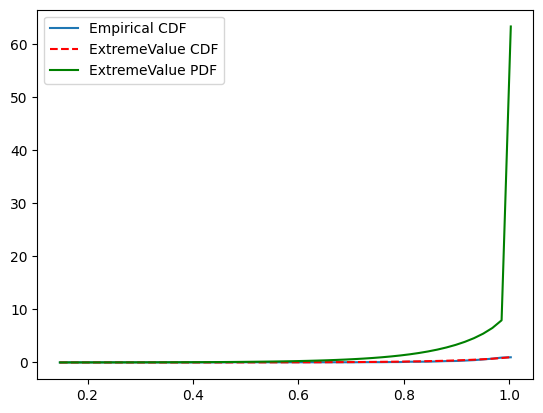

In [49]:
from scipy.stats import norm, poisson, expon, gamma, genextreme, gaussian_kde, chisquare, kstest
from scipy.integrate import quad

def fit(data, func):
    if func == poisson:
        return [np.mean(data)] # using the mean of the data as parameter
    if func == gaussian_kde:
        return gaussian_kde(data)
    return func.fit(data)

def gaussian_cdf(x, kde):
    cdf_values = np.zeros_like(x)  # Initialize array for CDF values
    for i, xi in enumerate(x):
        cdf_values[i], _ = quad(kde.pdf, -np.inf, xi)  # Integrate KDE's PDF up to xi
    return cdf_values

def cdf(data, pd, params):
    if pd == gaussian_kde:
        return gaussian_cdf(data, params)
    return pd.cdf(data, *params)

def pdf(data, pd, params):
    if pd == gaussian_kde:
        return params.pdf(data)
    return pd.pdf(data, *params)

class PDF():

    def __init__(self, func, params) -> None:
        self.func = func
        self.params = params

    def calc(self, x):
        return pdf(x, self.func, self.params)


distributions = {'Normal': norm,
                 'Poisson': poisson,
                 'Exponetial': expon,
                 'Gamma': gamma,
                 'ExtremeValue': genextreme,
                 'Kernel': gaussian_kde}

feature_pdfs = {"n_50":None,
                "n_150":None,
                "n_300":None,
                "d_50":None,
                "d_150":None,
                "d_300":None,
                "t_peak":None,
                "x_500":None,}

values_must_be_positive =["Poisson", "Exponential", "Gamma"]

for f in feature_names:
    print('')
    print(f'Check for feature: {f}')
    # Get x
    x_values = np.linspace(df[f].min(), df[f].max()) 
    
    # Get empirical CDF
    cum_prob = [len(df[df[f] < x])/len(df[f]) for x in x_values]

    for dist, func in distributions.items():
        if df[f].min() < 0 and dist in values_must_be_positive:
            continue

        params = fit(df[f], func)
        res = kstest(df[f], lambda x: cdf(x, func, params))

        # check KS-Test
        if res.pvalue < 0.05:
            print(f'Not {dist} with 5% significance level')
        else:
            expected = cdf(df[f], func, params) # need to do the following steps, otherwise I got errors in the chisquare function using this API
            total_expected = sum(expected)
            total_observed = sum(df[f])
            expected = [freq * total_observed / total_expected for freq in expected]
            _, p_value = chisquare(df[f], f_exp=expected)

            # check Chi² Test
            if p_value < 0.05:
                print(f'Not {dist} with 5% significance level')
            else:
                print(f'{dist} with 5% significance level')
                print(f'Params: {params}')

                # Plot CDF
                plt.plot(x_values, cum_prob, label='Empirical CDF')

                # # Plot fitted CDF
                plt.plot(x_values, cdf(x_values, func, params), c='r', label=f'{dist} CDF', linestyle='--')

                # # Plot PDF
                plt.plot(x_values, pdf(x_values, func, params), c='g', label=f'{dist} PDF')

                plt.legend()
                plt.show()

                feature_pdfs[f] = PDF(func, params)
                break



*Describe the fitted distributions. Your answer goes here.*

### 1.5 Joint and conditional probabilities, chain rule and Bayes’ Theorem

Lets calculate the probability of having a mild start and a disastrous end of the epidemia. We
translate that to the joint probability that no more than 4% are infected after 50 days, i.e.,
N50 ≤ 4% and more than 0.95% die in the end, i.e., X500 > 0.95%.

In [25]:
pos = len(df[(df['n_50'] <= 4) & (df['x_500'] > 0.95)])
print(f'positive cases: {pos}')

all = len(df)
P = pos/all
print(f'P: {P}')

positive cases: 1
P: 0.02


*Student: So $P(N_{50} ≤ 4\%,X_{500} > 0.95\%)$ ≈ 0.02 in my case, since I worked with only 50 countries instead of 125.*

We check the product of the two probabilities $P(N_{50} ≤ 4\%)P(X_{500} > 0.95\%)$:

In [26]:
p_n50 = len(df[df['n_50'] <= 4])/len(df)
p_x500 = len(df[df['x_500'] > 0.95])/len(df)

P2 = p_n50 * p_x500
print(f'P2: {P2}')

P2: 0.1428


We are not surprised that the result is different from the joint probability as the random variables
N50 and X500 not independent (double-check the results from the correlation analysis).

*Student: This holds in my case too*

What is the conditional probability of more than 0.95% die in the end given that we know that
no more 4% are infected after 50 days.

In [27]:
P_AB = pos/len(df[df['n_50'] <= 4])

print(f'P_AB: {P_AB}')

P_AB: 0.058823529411764705


*Student: So $P(X_{500} > 0.95\%|N_{50} ≤ 4\%) ≈ 0.0213$.*


The product or chain rule of probability states that

$P(A,B) = P(A|B)P(B) (5)$

$P(X_{500} > 0.95\%,N_{50} ≤ 4\%) = P(X_{500} > 0.95\%|N_{50} ≤ 4\%)P(N_{50} ≤ 4\%) (6)$

And we don’t get disappointed:

In [28]:
P = P_AB * p_n50
print(f'P: {P}')

P: 0.02


Let us numerically confirm Bayes’ Theorem for this case. We’d expect that.

\begin{align}
P(A|B) = \frac{P(B|A)P(A)}{P(B)}\\

P(X_{500} > 0.95\%|N_{50} ≤ 4\%) = \frac{P(N_{50} ≤ 4\%|X_{500} > 0.95\%)P(X_{500} > 0.95\%)}{P(N_{50} ≤ 4\%)}
\end{align}


And we don’t get disappointed:

In [29]:
P_BA = pos/len(df[df['x_500'] > 0.95])
P_AB = P_BA * p_x500 / p_n50

print(f'P_AB: {P_AB}')

P_AB: 0.05882352941176469


So far, we have looked at the joint (sample) probability of $P(N_{50} ≤ n,X_{500} > x)$ for concrete
bounds n = 4 and x = 0.95. Let us now understand the joint (sample) probability of $F(n, x) =
P(N_{50} ≤ n,X_{500} > x)$ as a function of these bounds n and x. Since, $0 ≤ X_{500} ≤ 100$ (*Student: In my case $0 ≤ X_{500} ≤ 1$*) this function
is equal to joint (sample) cumulative distribution function:

\begin{align}
F(n, x) = CDF_{N_{50},100−X_{500}}(n, 100 − x)\\

CDF_{N_{50},100−X_{500}}(n, y) = P(N_{50} ≤ n, 100 − X_{500} ≤ y)

\end{align}

In [30]:
# define cdf and F function

def cdf_sample(df,n,y):
    pos_cases = len(df[(df['n_50'] <= n) & (df['x_500'].apply(lambda x: 1-x) <= y)])
    return pos_cases/len(df)

def F(df, n, x):
    cdf = cdf_sample(df,n,1-x)
    return cdf

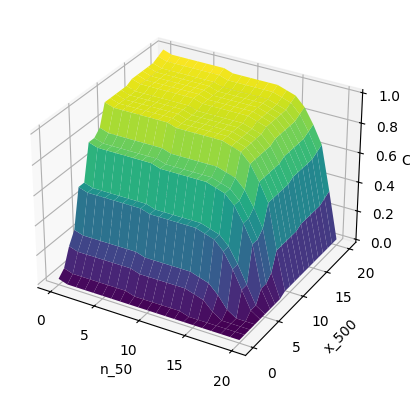

In [31]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D


_, n_50_bin_edges = np.histogram(df['n_50'], bins=20)
_, x_500_bin_edges = np.histogram(df['x_500'], bins=20)


# Generate meshgrid for plotting
x_sequence = range(len(n_50_bin_edges))
y_sequence = range(len(x_500_bin_edges))

X, Y = np.meshgrid(x_sequence, y_sequence)

# Initialize an empty matrix to store computed values
Z = np.zeros((len(x_sequence), len(y_sequence)))

# Compute values for each pair of elements using a nested loop
for x in x_sequence:
    for y in y_sequence:
        Z[x, y] = F(df, n_50_bin_edges[x], x_500_bin_edges[y])

# Plot the surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Set labels and title
ax.set_xlabel('n_50')
ax.set_ylabel('x_500')
ax.set_zlabel('CDF')

plt.show()

*Interprete this CDF. Your answer goes here.*

Finally, we compare a function interpolating a sample distribution with the fitted parameterized
PDF of that distribution computed earlier, cf. distribution_fitting. We look at N50 and X500
as two examples.

Therefore, we generate auxiliary functions plotPDF for plotting both functions, and two alternatives
samplePDF and parzanPDF for interpolating the sample distribution. The former is simple to use
and often good enough. The latter allows for fine tuning and is described in detail in the public
notebook “Approximate PDFs with Parzen window density estimation”.

In [32]:
from scipy.interpolate import interp1d

def samplePDF(sample, pd_fit):
    kde = gaussian_kde(sample)
    xi = np.linspace(-100, 100, 1000)
    f = kde.evaluate(xi)
    pdf = interp1d(xi, f)

    x = np.linspace(min(sample), max(sample), 1000)

    plt.plot(x, pdf(x), label='SamplePDF')
    plt.plot(x, pd_fit.calc(x), label='Fitted PDF')
    plt.legend()
    plt.show()
    return pdf

In [33]:
def parzanPDF(sample, a, b, h, pd_fit):
    x = np.linspace(a, b, 1000)
    mu = 0
    sigma = 1
    len_x = len(x)
    len_s = len(sample)
    f = np.zeros((len_x))
    for j in range(len_x):
        xi=x[j]
        for i in range(len_s):
            f[j] = f[j] + norm.pdf((xi-sample[i])/h, mu, sigma)
        f[j] = f[j] / (len_s*h)

    pdf = interp1d(x, f)

    x = np.linspace(min(sample), max(sample), 1000)

    plt.plot(x, pdf(x), label='ParzanPDF')
    plt.plot(x, pd_fit.calc(x), label='Fitted PDF')
    plt.legend()
    plt.show()
    return pdf

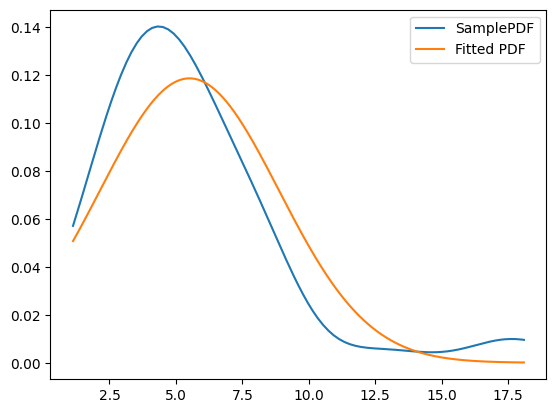

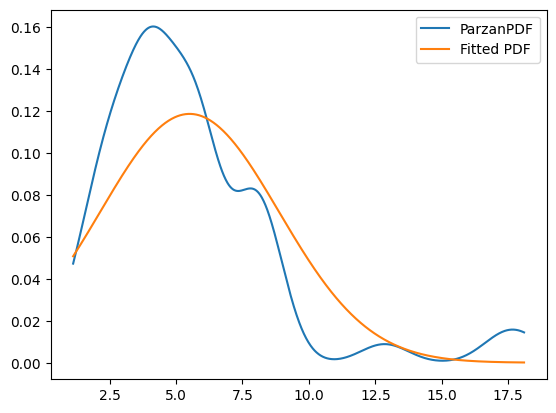

In [34]:
pd_n_50 = feature_pdfs['n_50']
samplePDF_n_50 = samplePDF(df['n_50'], pd_n_50)
PDF_n_50 = parzanPDF_n_50 = parzanPDF(df['n_50'], 0, 25, 0.9, pd_n_50)

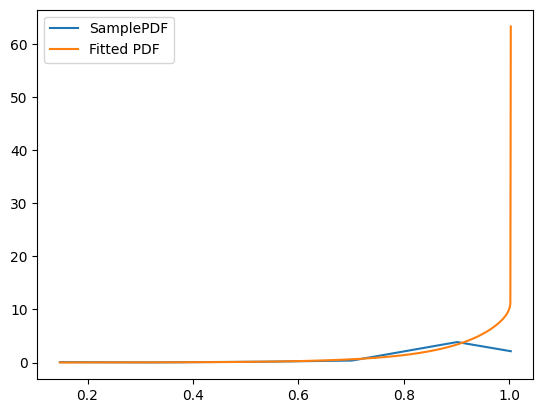

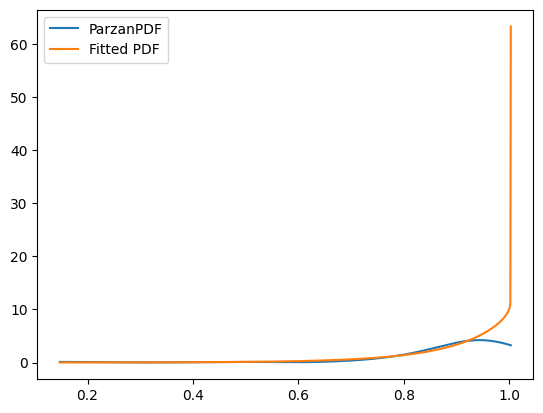

In [35]:
pd_x_500 = feature_pdfs['x_500']
PDF_x_500 = samplePDF_n_50 = samplePDF(df['x_500'], pd_x_500)
parzanPDF_n_50 = parzanPDF(df['x_500'], 0, 2, 0.07, pd_x_500)

### 1.6 Self-entropy of an event and entropy of a distribution

We define a function that calculates the entropy of a sample distribution, based on a interploated
parameterless PDF approximation (calculated with samplePDF and parzanPDF, resp.) and the
well-known parameterized distribition (calculated with distribution_fitting). We also compute
the Kullback-Leibler (KL) divergence in both directions.


For demonstration purpose, we implement numeric integration manually as auxiliary function. It comes in two variants: trapezoid and simpson’s 3/8 rule.

In [36]:
def trapez(f, a, b):
    N = int((b - a) * 100)
    x = np.linspace(a, b, N)
    dx = x[1] - x[0]
    y = np.zeros(N)
    for i in range(N):
        z = f(x[i])
        y[i] = z
    w = np.concatenate(([0.5], np.ones(N-2), [0.5]))
    I = np.sum(w * y) * dx
    return I

In [37]:
def simpson(f, a, b):
    N = 3 * (b - a) * 100 + 1
    x = np.linspace(a, b, N)
    dx = x[1] - x[0]
    I = 0
    for i in range(0, N - 3, 3):
        z0 = f(x[i])
        z1 = f(x[i + 1])
        z2 = f(x[i + 2])
        z3 = f(x[i + 3])
        I += z0 + 3 * z1 + 3 * z2 + z3
    I *= (3 * dx / 8)
    return I

In [38]:
def ite(b,t,f):
    return t if b else f

In [39]:
import math

a = 0 # n_50 with parzen is fitted in interval [0:25]
b = 25
f1  = lambda x : ite(PDF_n_50(x) <= 0, 0, PDF_n_50(x))
entropy1 = lambda x : -1 * ite(PDF_n_50(x) <= 0, 0, PDF_n_50(x) * math.log(PDF_n_50(x)))

Integral1 = trapez(f1, a, b)
Entropy1 = trapez(entropy1, a, b)

print(f'Integral1 = {Integral1}')
print(f'Entropy1 = {Entropy1}')

Integral1 = 0.9960982960592849
Entropy1 = 2.383020004321767


In [45]:
f2  = lambda x : ite(pd_n_50.calc(x) <= 0, 0, pd_n_50.calc(x))
entropy2 = lambda x : -1 * ite(pd_n_50.calc(x) <= 0, 0, pd_n_50.calc(x) * math.log(pd_n_50.calc(x)))

Integral2 = trapez(f2, a, b) 
Entropy2 = trapez(entropy2, a, b)

print(f'Integral2 = {Integral2}')
print(f'Entropy2 = {Entropy2}')

Integral2 = 0.94939366558359
Entropy2 = 2.4130503620782124


In [47]:
divergence_1_2 = lambda x : ite(PDF_n_50(x) <= 0, 0, PDF_n_50(x) * (math.log(PDF_n_50(x)) - math.log(pd_n_50.calc(x)) ))

Divergence_1_2_trapez = trapez(divergence_1_2, a, b)
Divergence_1_2_simposon = simpson(divergence_1_2, a, b)

print(f'Divergence_1_2_trapez = {Divergence_1_2_trapez}')
print(f'Divergence_1_2_simpson = {Divergence_1_2_simposon}')

Divergence_1_2_trapez = 0.2700321884595418
Divergence_1_2_simpson = 0.27003210906674346


In [48]:
eps = 1e-32
divergence_2_1 = lambda x : ite(PDF_n_50(x) <= 0, 
                                pd_n_50.calc(x)*(math.log(pd_n_50.calc(x)) - math.log(eps)), 
                                pd_n_50.calc(x) * ( math.log(pd_n_50.calc(x)) - math.log(PDF_n_50(x))))

Divergence_2_1_trapez = trapez(divergence_2_1, a, b)
Divergence_2_1_simposon = simpson(divergence_2_1, a, b)

print(f'Divergence_2_1_trapez = {Divergence_2_1_trapez}')
print(f'Divergence_2_1_simpson = {Divergence_2_1_simposon}')

Divergence_2_1_trapez = 0.14106013295715455
Divergence_2_1_simpson = 0.14105986379397267


*Why is the entropy of N50 assuming is proportional to the interpolated PDF different from the one assuming it is proportional to the fitted PDF? Why are the KL divergences different? Your answers go here.*